In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

import matplotlib
matplotlib.rc('xtick', labelsize=40) 
matplotlib.rc('ytick', labelsize=40) 

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)


import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

In [2]:
data = pd.read_csv("historic_sales.csv", names=['Store','Dept','Date','Weekly_Sales','isHoliday'],sep='|', header=0)
features = pd.read_csv("features.csv",sep='|', header=0, names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("store_info.csv", names=['Store','Type','Size'],sep=';', header=0)

C:\Users\Abhishek\Anaconda2\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,Store,Dept,Date,Weekly_Sales,isHoliday
0,1,1,2010-02-05,"24924,5",False
1,1,1,2010-02-12,"46039,49",True
2,1,1,2010-02-19,"41595,55",False
3,1,1,2010-02-26,"19403,54",False
4,1,1,2010-03-05,"21827,9",False


In [4]:
#Replace ',' with ''
data['Weekly_Sales'] = data['Weekly_Sales'].replace(np.nan, '', regex=True).str.replace(',','')

In [5]:
# Fill the nan values and convert the datatype from str to int.
data['Weekly_Sales'] = pd.to_numeric(data['Weekly_Sales'], errors='coerce').fillna(0).astype(int)

In [6]:
total = data.isnull().sum(axis=0).sort_values(ascending=False)
percent = ((data.isnull().sum(axis=0)/data.isnull().count(axis=0))*100).sort_values(ascending=False)

# count the number of null values in the column and their perecentage of the total data
missing_data_columns = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_columns

,Total,Percent
isHoliday,1,0.000237
Weekly_Sales,0,0.000000
Date,0,0.000000
Dept,0,0.000000
Store,0,0.000000


In [7]:
# Convert object to datetime
data['Date'] = pd.to_datetime(data['Date'], errors = 'coerce')

In [8]:
df = data.groupby('Date')['Weekly_Sales'].sum().reset_index()

In [9]:
df = df.set_index('Date')
df.index

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=143, freq=None)

In [10]:
df.dtypes

Weekly_Sales    float64
dtype: object

In [11]:
data['Date'].head()

0   2010-02-05
1   2010-02-12
2   2010-02-19
3   2010-02-26
4   2010-03-05
Name: Date, dtype: datetime64[ns]

In [12]:
import calendar
data['Day_Of_Week'] = data['Date'].dt.dayofweek.fillna(0).astype(int)
data['Month'] = data['Date'].dt.month.fillna(0).astype(int)
data['Year'] = data['Date'].dt.year.fillna(0).astype(int)
data['Day'] = data['Date'].dt.day.fillna(0).astype(int)

In [13]:
data.head()

,Store,Dept,Date,Weekly_Sales,isHoliday,Day_Of_Week,Month,Year,Day
0,1,1,2010-02-05,249245,False,4,2,2010,5
1,1,1,2010-02-12,4603949,True,4,2,2010,12
2,1,1,2010-02-19,4159555,False,4,2,2010,19
3,1,1,2010-02-26,1940354,False,4,2,2010,26
4,1,1,2010-03-05,218279,False,4,3,2010,5


In [14]:
copy_data=df.copy()

In [15]:
copy_data.head()

,Weekly_Sales
Date,
2010-02-05,4.342546e+09
2010-02-12,4.315691e+09
2010-02-19,4.303063e+09
2010-02-26,3.959016e+09
2010-03-05,4.142275e+09


In [16]:
dataset=data[data.Store==1]

In [17]:
dataset = dataset.set_index(dataset['Date'])

In [18]:
dataset.head()

,Store,Dept,Date,Weekly_Sales,isHoliday,Day_Of_Week,Month,Year,Day
Date,,,,,,,,,
2010-02-05,1,1,2010-02-05,249245,False,4,2,2010,5
2010-02-12,1,1,2010-02-12,4603949,True,4,2,2010,12
2010-02-19,1,1,2010-02-19,4159555,False,4,2,2010,19
2010-02-26,1,1,2010-02-26,1940354,False,4,2,2010,26
2010-03-05,1,1,2010-03-05,218279,False,4,3,2010,5


## Outlier Removal 

In [19]:
dataset_copy = dataset.copy()
dataset_copy = dataset_copy.drop(['Date', 'isHoliday'], axis = 1)
dataset_copy.head()

,Store,Dept,Weekly_Sales,Day_Of_Week,Month,Year,Day
Date,,,,,,,
2010-02-05,1,1,249245,4,2,2010,5
2010-02-12,1,1,4603949,4,2,2010,12
2010-02-19,1,1,4159555,4,2,2010,19
2010-02-26,1,1,1940354,4,2,2010,26
2010-03-05,1,1,218279,4,3,2010,5


In [20]:
Q1 = dataset_copy['Weekly_Sales'].quantile(0.25)
Q3 = dataset_copy['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

2663476.75


In [21]:
outlier_copy = ((dataset_copy['Weekly_Sales'] < (Q1 - 1.5 * IQR)) |(dataset_copy['Weekly_Sales'] > (Q3 + 1.5 * IQR)))

In [22]:
dataset_weekly_out = dataset_copy['Weekly_Sales'][~outlier_copy]

In [23]:
dataset_weekly_out.isnull().shape

(9601,)

## ...........................................................................

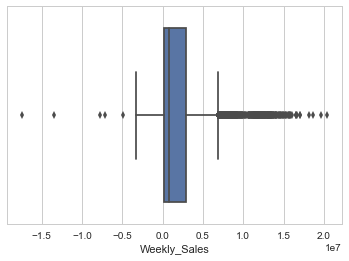

In [24]:
import seaborn as sns
sns.boxplot(x=dataset['Weekly_Sales'])

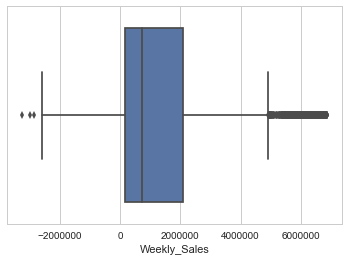

In [25]:
# Without Outlier
import seaborn as sns
sns.boxplot(x=dataset_weekly_out)
plt.savefig("Outlier Removal")

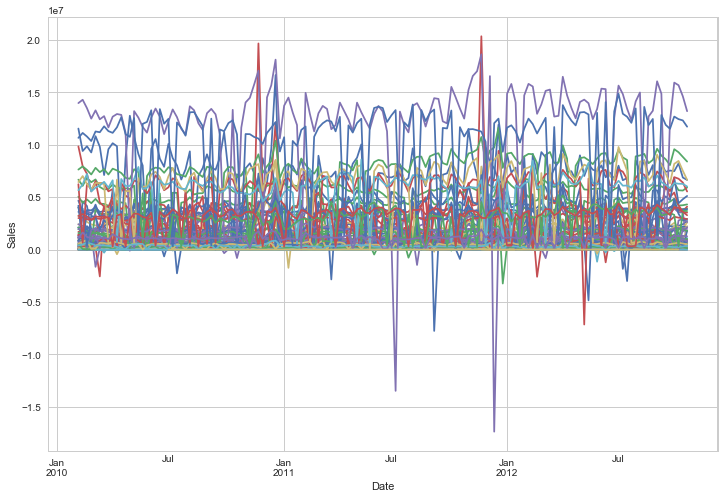

In [26]:
plt.figure(figsize=(12,8))
for i in dataset.Dept.unique():
    dataset_=dataset[dataset['Dept']==i]
    dataset_['Weekly_Sales'].plot()
    plt.savefig('Weekly_Sales at different dates')
    plt.xlabel('Date')
    plt.ylabel('Sales')

In [27]:
dataset_1=dataset[dataset.Dept==1]

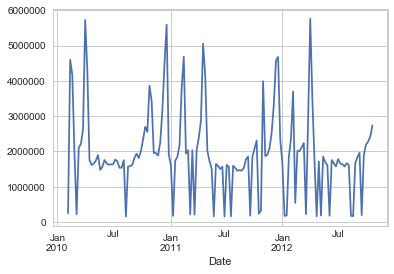

In [28]:
dataset_1['Weekly_Sales'].plot()
plt.savefig("Weekly_Sales of Department 1")

In [29]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dataset_1['Weekly_Sales'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.709722e+00
p-value                        1.273372e-11
#lags Used                     0.000000e+00
Number of Observations Used    1.420000e+02
Critical Value (1%)           -3.477262e+00
Critical Value (5%)           -2.882118e+00
Critical Value (10%)          -2.577743e+00
dtype: float64


 p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [30]:
dataset_1.head()

,Store,Dept,Date,Weekly_Sales,isHoliday,Day_Of_Week,Month,Year,Day
Date,,,,,,,,,
2010-02-05,1,1,2010-02-05,249245,False,4,2,2010,5
2010-02-12,1,1,2010-02-12,4603949,True,4,2,2010,12
2010-02-19,1,1,2010-02-19,4159555,False,4,2,2010,19
2010-02-26,1,1,2010-02-26,1940354,False,4,2,2010,26
2010-03-05,1,1,2010-03-05,218279,False,4,3,2010,5


In [31]:
dataset_1.head()

,Store,Dept,Date,Weekly_Sales,isHoliday,Day_Of_Week,Month,Year,Day
Date,,,,,,,,,
2010-02-05,1,1,2010-02-05,249245,False,4,2,2010,5
2010-02-12,1,1,2010-02-12,4603949,True,4,2,2010,12
2010-02-19,1,1,2010-02-19,4159555,False,4,2,2010,19
2010-02-26,1,1,2010-02-26,1940354,False,4,2,2010,26
2010-03-05,1,1,2010-03-05,218279,False,4,3,2010,5


In [32]:
monthly_sales_data = pd.pivot_table(dataset_1, values = "Weekly_Sales", columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = [1,2,3,4,5,6,7,8,9,10,11,12])
monthly_sales_data

Year,2010,2011,2012
Month,,,
1,NaN,1338071.50,961795.00
2,2738275.75,3144065.75,2150730.25
3,1789800.75,1121949.75,1895672.20
4,3010335.20,3301139.00,2772182.00
5,1667353.75,1352107.00,1361130.00
6,1668517.50,1574464.25,1354942.80
7,1638300.20,1016782.80,1661719.75
8,1264901.25,1476548.75,1055803.60
9,1797831.75,1433660.80,1470288.75


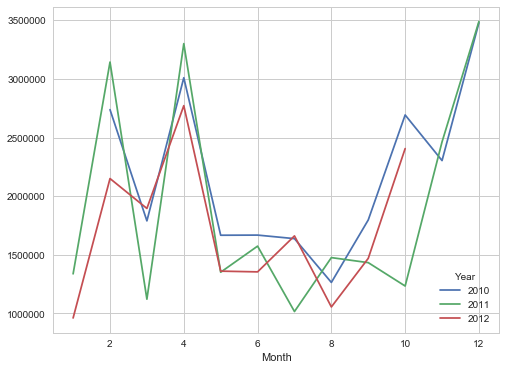

In [33]:
monthly_sales_data.plot(figsize=(8,6))

In [34]:
yearly_sales_data = pd.pivot_table(dataset_1, values = "Weekly_Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[[1,2,3,4,5,6,7,8,9,10, 11, 12]]
yearly_sales_data

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2010,NaN,2738275.75,1789800.75,3010335.2,1667353.75,1668517.50,1638300.20,1264901.25,1797831.75,2692890.6,2304035.00,3479677.6
2011,1338071.5,3144065.75,1121949.75,3301139.0,1352107.00,1574464.25,1016782.80,1476548.75,1433660.80,1234207.5,2463437.75,3490241.4
2012,961795.0,2150730.25,1895672.20,2772182.0,1361130.00,1354942.80,1661719.75,1055803.60,1470288.75,2406114.0,NaN,NaN


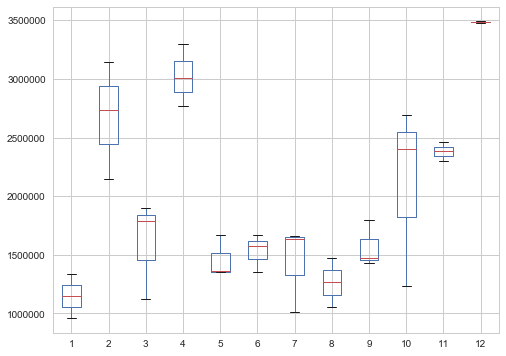

In [35]:
yearly_sales_data.boxplot(figsize=(8,6))

In [36]:
decomposition = sm.tsa.seasonal_decompose(dataset_1['Weekly_Sales'], model='multiplicative')

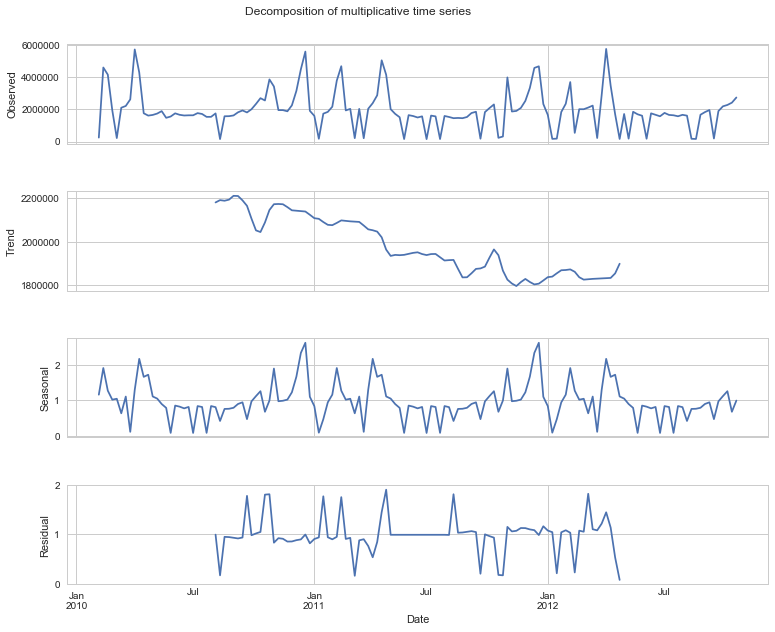

In [37]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(10)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

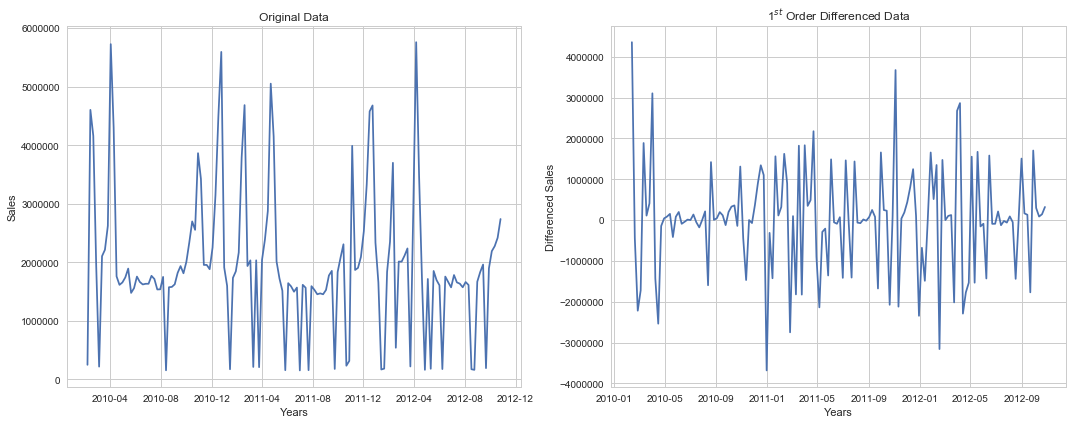

In [38]:
random_df=pd.DataFrame(dataset_1['Weekly_Sales'])

fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(15)
fig.set_figheight(6)

axes[0].plot(random_df.index, random_df['Weekly_Sales'])
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Sales")
axes[0].set_title("Original Data")

axes[1].plot(random_df.index, random_df['Weekly_Sales'].diff(periods=1))
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Differenced Sales")
axes[1].set_title("1$^{st}$ Order Differenced Data")

plt.tight_layout()
plt.show()

In [39]:
ts_log = np.log10(random_df)
ts_log.dropna(inplace=True)

ts_log_diff = ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
ts_log_diff.dropna(inplace=True)

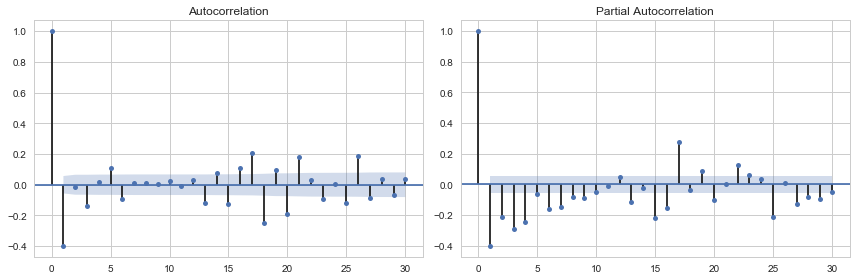

In [40]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()
plt.savefig("Selection of Autocorrelation")

In [41]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [42]:
import warnings
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(0, 0, 0, 12)12 model - AIC:151.3682782885412


In [43]:
best_model = sm.tsa.statespace.SARIMAX(ts_log,
                                      order=(1, 1, 1),
                                      seasonal_order=(0, 0, 0, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [44]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                           Statespace Model Results                           
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -72.684
Date:                Tue, 22 Jan 2019   AIC                            151.368
Time:                        16:42:07   BIC                            160.236
Sample:                    02-05-2010   HQIC                           154.972
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1399      0.101      1.383      0.167      -0.058       0.338
ma.L1         -0.9827      0.033    -29.982      0.000      -1.047      -0.918
sigma2         0.1595      0.015     10.570      0.0

In [45]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-06-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [46]:
ts_forecasted = pred_dynamic.predicted_mean
ts_truth = ts_log['2012-06-01':]

# Compute the mean square error
mse = ((ts_forecasted - ts_truth['Weekly_Sales']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.1651


In [47]:
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [48]:
n_steps = 36
idx = pd.date_range(dataset_1.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2012-11-01,1.510743e+06,249133.069030,9.161142e+06,249133.069030,9.161142e+06
2012-12-01,1.390039e+06,224192.234981,8.618530e+06,224192.234981,8.618530e+06
2013-01-01,1.373934e+06,221287.769459,8.530501e+06,221287.769459,8.530501e+06
2013-02-01,1.371696e+06,220824.396308,8.520565e+06,220824.396308,8.520565e+06
2013-03-01,1.371383e+06,220691.211338,8.521817e+06,220691.211338,8.521817e+06


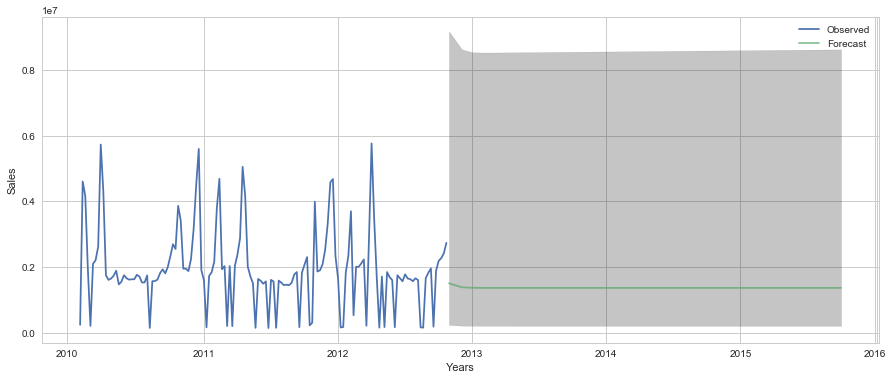

In [49]:
axis = dataset_1['Weekly_Sales'].plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.75)
axis.set_xlabel('Years')
axis.set_ylabel('Sales')
plt.legend(loc='best')
plt.show()